In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
import os
from themachinethatgoesping.echosounders.simrad import FileRaw,FileRaw_mapped,SimradDatagram_type_from_string,datagram_type_to_string,t_SimradDatagramType
import themachinethatgoesping.echosounders.simrad as simrad
import themachinethatgoesping.echosounders.simrad.datagrams as dg
import themachinethatgoesping.tools.progressbars as prg
import themachinethatgoesping.tools as tools
import themachinethatgoesping.navigation.nmea_0183 as NMEA
import numpy
import os, sys
from time import time
from tqdm.auto import tqdm
from collections import defaultdict
import numpy as np

#load files
folders =  ["/home/data/"]
#folders =  ["/home/data/turbeams/"]

files = []
for folder in folders:
    for r,d,f in os.walk(folder):
        for file in f:
            if file.endswith('.raw'):
                files.append(r + '/' +file)
            
files.sort()
#files
file_name = files[0]

In [2]:
fm = FileRaw_mapped(files)
print(fm)

indexing files ⢀ 100% :03s<00m:00s] [Found: 4819575 packages in 115 files (30084MB)]                                                
FileSimradRaw
#############
- Number of loaded .raw files: : 115      
- Total file size: :             29.38 GB 

 Detected datagrams 
-------------------- 
- Total:           4819575 
- Packages [TAG0]: 8       [Annotation datagram]
- Packages [XML0]: 1007296 [XML0 text datagram]
- Packages [RAW3]: 610748  [Sample binary datagram]
- Packages [FIL1]: 718     [Filter binary datagram]
- Packages [NME0]: 2590057 [NMEA text datagram]
- Packages [MRU0]: 610748  [Motion binary datagram]


In [38]:
#%%timeit -n1 -r1
fail = 0
for ping in tqdm(fm.pings()):
    ping.get_sv(dB = True)

  0%|          | 0/610748 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
#pings = fm.pings(0,-1,100)
#pings = fm.pings(178000,185000,1)
pings = fm.pings(-280000,290000,1)

nsamples = min(7000,pings.max_number_of_samples())
#nsamples = 7000

image = np.empty((len(pings),nsamples),dtype=np.float32)
image.fill(np.nan)

for i,ping in enumerate(tqdm(pings)):
    sv = ping.get_sv_stacked(dB = True)
    #sv = ping.sample_data.get_power(dB = True)
    ns = min(nsamples,len(sv))
    image[i,:ns] = sv[:ns]
    

  0%|          | 0/40749 [00:00<?, ?it/s]

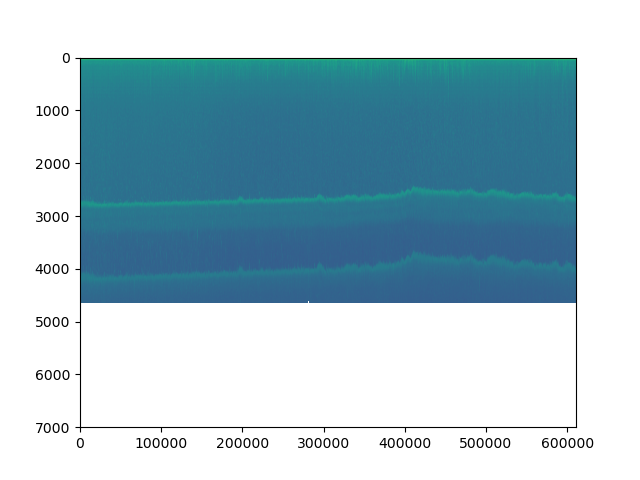

In [41]:
plt.close("echo")
fig = plt.figure("echo")
ax = fig.subplots()
ax.imshow(image.transpose(), aspect = 'auto', extent = [0,len(fm.pings()),7000,0])

In [4]:
#%%timeit -n1 -r1
for ping in tqdm(fm.pings()):
    ping.raw().sample_data().get_power()

  0%|          | 0/610748 [00:00<?, ?it/s]

In [6]:
#%%timeit -n1 -r1
for ping in tqdm(fm.pings()):
    ping.raw().sample_data()

  0%|          | 0/610748 [00:00<?, ?it/s]

In [4]:
ping.get_sv()

array([1.7469267e+02, 5.8940961e+02, 1.6111578e+03, ..., 7.4378593e-14,
       9.3292268e-15, 6.0727699e-16], dtype=float32)

In [11]:
ping.raw().sample_data()

Sample binary data (ComplexFloat32)
###################################
- complex_samples: {{{ 7.342804e-42, -3.363111e+00}, 
                    {-6.317870e-01, -3.316233e+00},
                    {-7.177230e-01, -3.378731e+00},
                    {-9.677227e-01, -3.019359e+00}},
                   {{-1.240134e+00, -6.132515e+00},
                    {-1.725970e-01, -6.070014e+00},
                    {-2.651156e-01, -6.195010e+00},
                    {-4.487092e-01, -5.882511e+00}},
                   {{-7.646059e-01, -1.007759e+01},
                    { 1.287040e+00, -9.952594e+00},
                    { 1.169852e+00, -1.014008e+01},
                    { 1.083914e+00, -1.001508e+01}},
                   ..., 
                   {{ 2.416054e-07,  1.436104e-07},
                    { 1.515348e-07,  9.508960e-08},
                    { 2.092760e-07,  1.729451e-07},
                    { 8.042404e-08,  4.475040e-08}},
                   {{ 1.013785e-07,  5.161903e-08},
             

In [12]:
a = ping.raw().sample_data()

In [14]:
a.get_power()

array([  37.863934 ,    0.       ,   -2.9162283, ..., -128.0436   ,
       -134.6051   , -143.636    ], dtype=float32)

In [10]:
#%%timeit -n1 -r1
for ping in tqdm(fm.i_RAW3):
    pass

  0%|          | 0/610748 [00:00<?, ?it/s]

4.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
import gc
del fm
gc.collect()

0

In [9]:
#%%timeit -n1 -r1
for f in tqdm(fm.i_RAW3_header):
    pass

  0%|          | 0/610748 [00:00<?, ?it/s]

In [ ]:
#%%timeit -n1 -r1
A = {}
for nm in tqdm(fm("TAG0",0,-1)):
    print(nm)

In [ ]:
t1 = time()
simrad.test_speed_raw(fm,"NME0")
t2 = time()
simrad.test_speed_type(fm,"NME0")
t3 = time()
simrad.test_speed_decode_nmea(fm)
t4 = time()
print(round(100*(t3-12)/(t2-t1),2))
print('raw :',len(fm('NME0'))/(t2-t1),'it/s')
print('read:',len(fm('NME0'))/(t3-t2),'it/s')
print('pack:',len(fm('NME0'))/(t4-t3),'it/s')